In [88]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, LeakyReLU, Input, Concatenate, Average
from tensorflow import keras
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd

In [89]:
TRAIN_SET = './ptb_train_set.pickle'
TEST_SET = './ptb_test_set.pickle'

with open(TEST_SET, 'rb') as file:
    test_set = pickle.load(file)
    x_test = test_set['x']
    y_test = test_set['y']

with open(TRAIN_SET, 'rb') as file:
    train_set = pickle.load(file)
    x_train = train_set['x']
    y_train = train_set['y']
    
x_train = tf.expand_dims(x_train, axis=2)
x_test = tf.expand_dims(x_test, axis=2)
x_train.shape

TensorShape([13097, 187, 1])

In [90]:
class EnsembleModel():
    def CNN(self, inputs):
        x = Conv1D(5, kernel_size=3, strides=1)(inputs)
        x = LeakyReLU()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = Conv1D(10, kernel_size=4, strides=1)(x)
        x = LeakyReLU()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = Conv1D(20, kernel_size=4, strides=1)(x)
        x = LeakyReLU()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        x = Flatten()(x)
        x = Dense(30)(x)
        x = LeakyReLU()(x)
        x = Dense(20)(x)
        x = LeakyReLU()(x)
        x = Dense(1, activation="sigmoid")(x)
        return x
    
    def LSTM(self, inputs):
        x = LSTM(64)(inputs)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(1, activation='sigmoid')(x)
        return x
    
    def MLP(self, inputs):
        x = Dense(5)(inputs)
        x = Dense(64, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1, activation="sigmoid")(x)
        return x

    def assemble(self, input_shape):
        inputs = Input(shape=input_shape)
        cnn = self.CNN(inputs)
        lstm = self.LSTM(inputs)
        mlp = self.MLP(inputs)
        #x = Concatenate(axis=1)([cnn, lstm, mlp])
        y = Average()([cnn, lstm, mlp])
        #y = Dense(1, activation="sigmoid")(x)

        model = Model(inputs = inputs, outputs = y)
        #model.trainable = False
        return model

In [91]:
LSTM = keras.models.load_model('LSTM_PTB')
CNN = keras.models.load_model('CNN_PTB')
MLP = keras.models.load_model('MLP_PTB')

inputs = Input(shape=x_train.shape[1:])
cnn = CNN(inputs)
lstm = LSTM(inputs)
mlp = MLP(inputs)

y = Average()([cnn, lstm, mlp])


model = Model(inputs = inputs, outputs = y)

In [92]:
#model = EnsembleModel().assemble(x_train.shape[1:])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1)            13721       input_25[0][0]                   
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            25345       input_25[0][0]                   
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            61963       input_25[0][0]                   
___________________________________________________________________________________________

In [93]:
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [94]:
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/20
103/103 [==============================] - 25s 213ms/step - loss: 0.2279 - accuracy: 0.9449 - val_loss: 0.2609 - val_accuracy: 0.9093
Epoch 2/20
103/103 [==============================] - 21s 202ms/step - loss: 0.2070 - accuracy: 0.9455 - val_loss: 0.2207 - val_accuracy: 0.9395
Epoch 3/20
103/103 [==============================] - 21s 205ms/step - loss: 0.2008 - accuracy: 0.9483 - val_loss: 0.2129 - val_accuracy: 0.9512
Epoch 4/20
103/103 [==============================] - 21s 205ms/step - loss: 0.1932 - accuracy: 0.9493 - val_loss: 0.2214 - val_accuracy: 0.9299
Epoch 5/20
103/103 [==============================] - 22s 210ms/step - loss: 0.1965 - accuracy: 0.9497 - val_loss: 0.2266 - val_accuracy: 0.9347
Epoch 6/20
103/103 [==============================] - 22s 215ms/step - loss: 0.1921 - accuracy: 0.9497 - val_loss: 0.2358 - val_accuracy: 0.9196
Epoch 7/20
103/103 [==============================] - 22s 215ms/step - loss: 0.1911 - accuracy: 0.9470 - val_loss: 0.2144 - val_ac

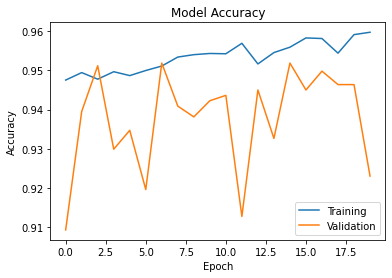

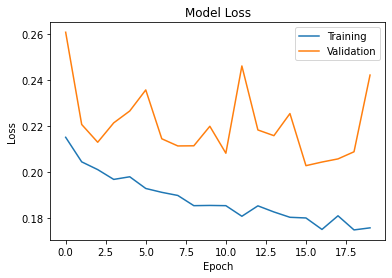

In [95]:
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'], loc='upper right')


plt.show()
